# Kripto paraların ilerki 30 gün için fiyat tahmini

#### Bilgilendirme:
    Kripto paralar, stok vesaire için yaptığımız bu tahminlerin hiçbiri gerçeği yansıtmamaktadır. Gerçek hayatta bu veriler çok daha tahmin edilemezdir, bu programın amacı LSTM modelini ve zaman-serisi verileri kullanmayı ve çalışma mantığını öğrenmektir.

### Gerekli kütüphaneleri ekliyoruz

In [17]:
""" veri işleme için pandas, numpy ve scikit-learn kullanacağız """
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

""" neural-networks için pytorch kütüphanesini lightning ile birlikte kullanacağız """
import torch
import torch.nn as nn
import lightning as L

""" backwards propagation sırasında optimizasyon için Adam fonksiyonunu kullanacağız """
from torch.optim import Adam

""" tensor veri seti oluşturmak için TensorDataset ve DataLoader kullanacağız """
from torch.utils.data import TensorDataset, DataLoader

""" ve son olarak verileri grafiğe dökmek için matplotlib kullanacağız """
import matplotlib.pyplot as plt

### Veri setini yükleyip, ön işlemeye başlıyoruz

In [18]:
""" veri setimizi yüklüyoruz, ben kripto paralardan monero'yu seçtim """
df = pd.read_csv('dataset/monero.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2015-01-30,0.311,0.350,0.303,0.303,1334,USD
1,2015-01-31,0.303,0.303,0.290,0.290,476,USD
2,2015-02-01,0.290,0.290,0.290,0.290,0,USD
3,2015-02-02,0.290,0.303,0.287,0.303,348,USD
4,2015-02-03,0.303,0.360,0.302,0.331,1473,USD


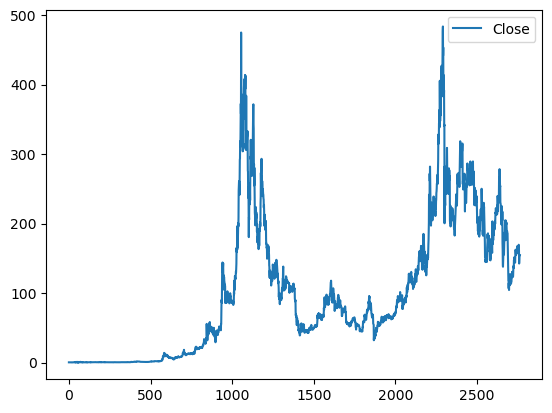

In [19]:
df[['Close']].plot()
plt.show()

In [12]:
""" LSTM modeli ile veri setindeki günlük kapanış değerlerini tahmin edeceğiz bu yüzden DataFrame'den 'Close' sütununun değerlerini değişkenimize atıyoruz """
data = df[['Close']].values

In [21]:
""" neural-network modelleri ile uğraşırken veri setini küçük bir ölçeğe indirmek önemlidir
genellikle veri setini MinMaxScaler kullanarak 0-1 aralığına indirilir bu da alt (0) ve üst (1)
sınır oluşturur fakat kripto para fiyatlarında herhangi bir üst sınır bulunmaz bu sebeple MinMaxScaler yerine StandardScaler kullanacağız """
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[-1.02566037],
       [-1.02579396],
       [-1.02579396],
       ...,
       [ 0.55888222],
       [ 0.55496708],
       [ 0.55950906]])

In [22]:
""" veri setini eğitim ve test için 80/20 şeklinde bölüyoruz """
train_data = scaled_data[:round(len(scaled_data)*0.8)]
test_data = scaled_data[round(len(scaled_data)*0.8):]
print(train_data.shape)
print(train_data)
print(test_data.shape)
print(test_data)

(2210, 1)
[[-1.02566037]
 [-1.02579396]
 [-1.02579396]
 ...
 [ 1.33599134]
 [ 1.31590184]
 [ 1.25073171]]
(553, 1)
[[1.76435497]
 [1.65595388]
 [1.86905671]
 [1.59863458]
 [1.5112581 ]
 [1.27672989]
 [1.24133949]
 [1.07243355]
 [0.99624759]
 [1.07028587]
 [1.12059697]
 [1.2096587 ]
 [1.33708059]
 [1.23994196]
 [1.22295579]
 [1.2058566 ]
 [1.08743645]
 [1.07462233]
 [1.11644548]
 [1.23981864]
 [1.28247415]
 [1.23634537]
 [1.24472028]
 [1.26081243]
 [1.42706717]
 [1.35807438]
 [1.25283828]
 [1.33033957]
 [1.39898297]
 [1.31640537]
 [1.34793201]
 [1.35415924]
 [1.35292612]
 [1.20174622]
 [1.21060409]
 [1.13841548]
 [1.17280912]
 [1.24641581]
 [1.2426137 ]
 [1.35810521]
 [1.38020879]
 [1.47940263]
 [1.50044779]
 [1.54389454]
 [1.61884739]
 [1.61242491]
 [1.67978383]
 [1.69902042]
 [1.74911572]
 [1.61355527]
 [1.73966184]
 [1.78060126]
 [1.97398453]
 [2.34370326]
 [2.20524499]
 [2.335092  ]
 [2.2673015 ]
 [2.5073068 ]
 [2.47050859]
 [2.70635212]
 [2.44901128]
 [2.64970076]
 [3.13806571]
 [2

In [23]:
""" veri setini LSTM modeline kaç zaman adımında (time-step) vereceğimizi ayarladığımız değişkeni belirliyoruz """
t = 45

""" train_data'dan train_input ve train_label verilerini batch first şeklinde oluşturuyoruz """
train_inputs = []
for i in range(train_data.shape[0]-t):
    train_inputs.append([])
    for j in range(train_data.shape[1]):
        train_inputs[i].append(train_data[i:i+t, j])

train_labels = np.roll(scaled_data[:train_data.shape[0]+1], -1)
train_labels = train_labels[t:train_data.shape[0]]

""" aynısını test_data'dan test_input ve test_label için de yapıyoruz """
test_inputs = []
test_labels = []
for i in range(test_data.shape[0]-t-1):
    test_inputs.append([])
    for j in range(test_data.shape[1]):
        test_inputs[i].append(test_data[i:i+t, j])
    
    test_labels.append([])
    test_labels[i].append(test_data[i+t+1,0])

In [24]:
train_inputs, train_labels, test_inputs, test_labels = np.array(train_inputs), np.array(train_labels), np.array(test_inputs), np.array(test_labels)
train_inputs, test_inputs = np.moveaxis(train_inputs, [1], [2]), np.moveaxis(test_inputs, [1], [2])

In [25]:
print(train_inputs.shape)
print(train_labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(2165, 45, 1)
(2165, 1)
(507, 45, 1)
(507, 1)


In [26]:
""" model rastegeliğini azaltmak için lightning kütüphanesini kullanarak rastegelik gerektiren her şey için seed belirliyoruz"""
L.seed_everything(1428, workers=True)
""" modelin tüm parametrelerinin aynı tür olması için varsayılan türü ayarlıyoruz """
torch.set_default_dtype(torch.float64)
""" eğitim için işlediğimiz input ve label verileri ile tensor veri seti oluşturuyoruz """
train_dataset = TensorDataset(torch.from_numpy(train_inputs), torch.from_numpy(train_labels))

Global seed set to 1428


In [27]:
""" ve model eğitiminde verileri kullanabilmek için veri yükleyici oluşturuyoruz (DataLoader), bilgisayarın işlemcisine göre eğitimi hızlandırmak için num_workers parametresine değer atıyoruz
loss hesaplamasında gelgit (oscillation) olmasın diye shuffle parametresini True yapıyoruz """
train_dataloader = DataLoader(train_dataset, num_workers=8, shuffle=True)

### Model sınıfını oluşturuyoruz

In [28]:
class LSTM(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        """ forward fonksiyonunda kullanmak üzere global değişken olarak atıyoruz """
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        """ backwards propagation'da kullanılması için bir learning rate belirliyoruz durumda göre arttırıp azaltabilir ya da
        lightning kütüphanesinden Tuner kullanarak optimize edebiliriz """
        self.lr = 0.01
        
        """ ana LSTM katmanını oluşturuyoruz, hiper-parametrelerinin değerlerini modeli oluştururken belirleyeceğiz, DataLoader'a verileri batch first olarak vereceğiz """
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        """ LSTM katmanının çıktısını düzenlemek için bağlayacağımız bir linear (fully-connected) katman oluşturuyoruz """
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

        """ neural-network'ü optimize ederken loss hesaplamak için kullanacağımız loss (error) fonksiyonumuzu belirliyoruz
        'Mean-Squared Error' fonksiyonunu kullanacağınız bu fonksiyon kısaca modelin çıktısı (output) ile hedefin (label) farkının karesini alıyor  """
        self.loss = nn.MSELoss()

    def forward(self, inputs):
        """ forward fonksiyonu neural-network'ün başından sonuna kadar veri akışının nasıl ya da hangi yönde olacağını ayarladığımız fonksiyondur """

        """ LSTM modelinin her bir hücresindeki short-term (hidden_state) ve long-term (cell_state) bellekleri tutacağımız iki tane 3 boyutlu tensor-array oluşturuyoruz 
        ve gradient hesaplaması yapılmasını aktif ediyoruz """
        hidden_states = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).requires_grad_()
        cell_states = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).requires_grad_()

        """ LSTM modeli bize short-term belleklerden oluşan bir tensor-array ve en sonuncu short-term ve long-term bellekten oluşan bir tensor-tuple döndürecek
        fakat bize sadece LSTM'in sonuncu short-term bellek değeri gerek """
        outputs, _ = self.lstm(inputs, (hidden_states.detach(), cell_states.detach()))

        """ döndürülen short-term bellek array içindeki sonuncu değer yani en sonuncu LSTM hücresinin döndürdüğü short-term (hidden-state) bellek değeri
        bizim tahmin için kullanacığımız değerdir, hidden_size değerimiz 1'den büyük olduğu için LSTM'in çıktısını linear katmandan geçirerek döndürüyoruz """
        return self.fc(outputs[:, -1, :])

    def configure_optimizers(self):
        """ neural-network train sıranında back-propagation yaparken kullanacağımız optimizer fonksiyonu daha önceden belirlediğimiz learning rate ile birlikte döndürüyoruz """
        return Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        """ lightning kütüphanesinin training sıransında çağıracağı ana train fonksiyonundur. Burada daha önceden tanımladığımız loss fonksiyonunu kullanarak loss hesaplıyacağız
        yanı sıra TensorBoard kullanarak sonuçları takip edebilmek için LighningModule'ünün logger'ını kullanarak sonuçları kaydediyoruz. """
        
        """ Dataloader'dan aldığımız (X,y) batch'i input ve label'a ayırıyoruz """
        inputs, label = batch
        
        """ inputs(X) değişkeninin forward fonksiyonuna gönderiyoruz """
        output = self.forward(inputs)
        
        """ label(y) değişkenini kullanarak çıktı üzerinde loss hesaplıyoruz"""
        loss = self.loss(output, label)
        
        """ TensorBoard için değişkenleri kaydediyoruz """
        self.log("train_loss", loss)
        self.log("lstm_output", output)

        """ son olarak loss değerini döndürüyoruz """
        return loss

### Modelin hiper-parametrelerini belirleyip eğitime başlıyoruz

In [29]:
""" modelimiz 1 tane özelliği (feature) olan veri alacak bu yüzden input_size'ı 1, LSTM'in short-term bellek (hidden_state) çıktısının
boyutunu 32 olarak belirledik (topluluk içinde bilindik varsayılan değerdir), LSTM modelinin hücre sayısını 2 olarak belirledik (aynı şekilde topluluk içinde kullanılan varsayılan değerdir)
ve son olarak çıktı boyutunu 1 olarak belirledik linear (fully-connected) katman LSTM'in çıktısını bu boyuta düşürecek """
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 1
model = LSTM(input_size, hidden_size, num_layers, output_size)

In [32]:
""" lightning kütüphanesinden trainer oluşturup epoch boyutunu belirliyoruz ve modelin çıktısında rastgelelik olmasını istemediğimiz için deterministic parametresini True yapıyoruz"""
trainer = L.Trainer(max_epochs=35, deterministic=True)
""" oluşturduğumuz trainer'a model'i ve eğitim veri setini verip eğitime başlatıyoruz """
trainer.fit(model=model, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type    | Params
---------------------------------
0 | lstm | LSTM    | 12.9 K
1 | fc   | Linear  | 33    
2 | loss | MSELoss | 0     
---------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


In [33]:
""" modeli dosyaya kaydediyoruz (her kullanımda tekrar eğitim döngüsünü çalıştırmak zorunda olmamak için) """
torch.save(model.state_dict(), 'model.pth')

### Modeli Test ediyoruz

In [31]:
""" modeli dosyadan yüklüyoruz (eğer daha önceden eğitimden geçmiş ise) """
model.load_state_dict(torch.load('models/model.pth'))

<All keys matched successfully>

In [34]:
""" modeli evaluate (hesaplama) moduna alıyoruz """
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (loss): MSELoss()
)

In [39]:
""" şuan model eğitimde olmadığı için pytorch tensorları gradient'leri ile birlikte çift olarak döndürmesin diye
test döngüsünü torch.no_grad() içerisinde çalıştıracağız """
predictions = []
with torch.no_grad():
    for i in range(test_inputs.shape[0]-1):
        output = model(torch.from_numpy(test_inputs[i:i+t,:]))
        #print(output.shape)
        predictions.append(output[0,0].numpy())

In [40]:
predictions = np.array(predictions).reshape(len(predictions), 1)
predictions.shape

(506, 1)

In [148]:
inverse_predictions = scaler.inverse_transform(predictions)
inverse_test_labels = scaler.inverse_transform(test_labels)
test_labels.shape

(507, 1)

In [94]:
test_dates = df[['Date']].iloc[round(len(df[['Date']])*0.8):]
test_dates = test_dates[test_dates.shape[0]-inverse_test_labels.shape[0]:].values.ravel()
test_dates

array(['2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07',
       '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11',
       '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
       '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
       '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
       '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
       '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01',
       '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05',
       '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09',
       '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',
       '2021-05-14', '2021-05-15', '2021-05-16', '2021-05-17',
       '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
       '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
       '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02',
       '2021-06-03', '2021-06-04', '2021-06-05', '2021-

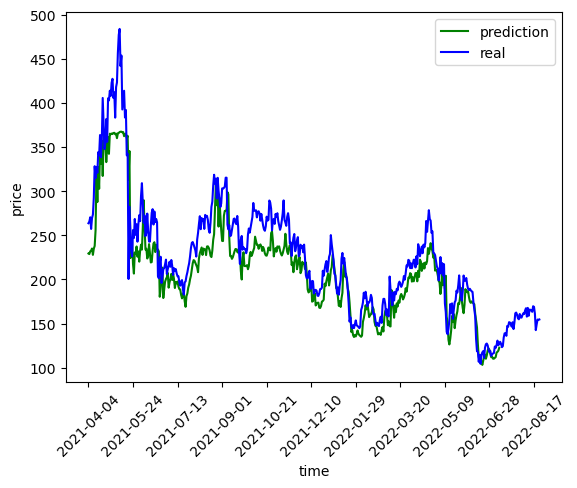

In [95]:
plt.plot(inverse_predictions, color='green', label='prediction')
plt.plot(inverse_test_labels, color='blue', label='real')
#df_dates_len = len(df[['Date']])
plt.xticks(range(0,inverse_test_labels.shape[0],50), test_dates[::50], rotation=45)
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()

In [96]:
pred_inputs = test_inputs[test_inputs.shape[0]-1:test_inputs.shape[0],:]
print(pred_inputs)
future_preds = []
with torch.no_grad():
    for i in range(30):
        output = model(torch.from_numpy(pred_inputs))
        np.roll(pred_inputs, -1)
        pred_inputs[-1,-1,-1] = output[0,0].numpy()
        future_preds.append(output[0,0].numpy())
        print(future_preds[-1])

future_preds

[[[0.26023203]
  [0.27820468]
  [0.29944509]
  [0.27608783]
  [0.23748106]
  [0.24911344]
  [0.34909852]
  [0.39818678]
  [0.39903968]
  [0.36913664]
  [0.48461787]
  [0.47544144]
  [0.52812628]
  [0.52443721]
  [0.50250831]
  [0.47517426]
  [0.52706786]
  [0.44814849]
  [0.5235021 ]
  [0.63192374]
  [0.64007258]
  [0.6143313 ]
  [0.57321719]
  [0.56179032]
  [0.62335359]
  [0.58217782]
  [0.58158182]
  [0.60885421]
  [0.63168739]
  [0.62332276]
  [0.66435467]
  [0.69026036]
  [0.59282372]
  [0.69432964]
  [0.60234953]
  [0.67472311]
  [0.67205136]
  [0.66289548]
  [0.64885852]
  [0.71343265]
  [0.7062703 ]
  [0.62679604]
  [0.4357043 ]
  [0.50340232]
  [0.55888222]]]
0.4325661917873891
0.34037929882544393
0.2818199082687103
0.24746782780077936
0.22795938602992938
0.217018133815996
0.21091296291897033
0.20751400304655987
0.20562373314163995
0.20457307042200634
0.2039892523586535
0.20366489458992842
0.2034847030928597
0.20338460540302994
0.20332900183733393
0.2032981148859898
0.20328095

[array(0.43256619),
 array(0.3403793),
 array(0.28181991),
 array(0.24746783),
 array(0.22795939),
 array(0.21701813),
 array(0.21091296),
 array(0.207514),
 array(0.20562373),
 array(0.20457307),
 array(0.20398925),
 array(0.20366489),
 array(0.2034847),
 array(0.20338461),
 array(0.203329),
 array(0.20329811),
 array(0.20328096),
 array(0.20327143),
 array(0.20326613),
 array(0.20326319),
 array(0.20326156),
 array(0.20326065),
 array(0.20326015),
 array(0.20325987),
 array(0.20325971),
 array(0.20325963),
 array(0.20325958),
 array(0.20325955),
 array(0.20325954),
 array(0.20325953)]

In [154]:
future_preds = np.array(future_preds).reshape(len(future_preds), 1)
inverse_future_preds = scaler.inverse_transform(future_preds)
inverse_future_preds

array([[142.20961611],
       [133.23849299],
       [127.53981407],
       [124.19685789],
       [122.29840327],
       [121.23366057],
       [120.63953881],
       [120.30877066],
       [120.12481996],
       [120.02257522],
       [119.96576125],
       [119.93419653],
       [119.91666128],
       [119.90692032],
       [119.90150928],
       [119.89850353],
       [119.8968339 ],
       [119.89590645],
       [119.89539128],
       [119.89510511],
       [119.89494615],
       [119.89485785],
       [119.89480881],
       [119.89478156],
       [119.89476643],
       [119.89475802],
       [119.89475335],
       [119.89475076],
       [119.89474932],
       [119.89474852]])

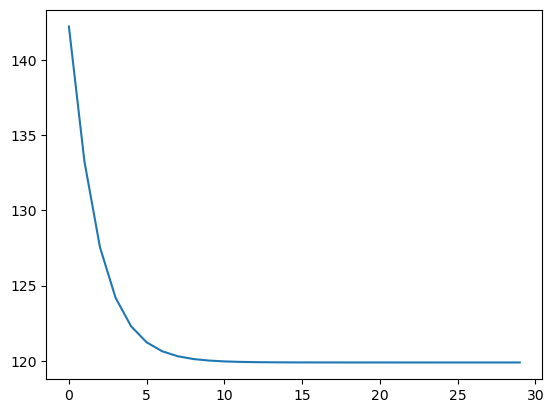

In [98]:
plt.plot(inverse_future_preds)
plt.show()

In [150]:

# sağdan 30 gün boşluk (30 gün tahmini ile grafite örtüşmesi için)
padder = np.full((inverse_predictions.shape[0]+30, 1), np.nan)
padder[:inverse_predictions.shape[0]] = inverse_predictions
inverse_predictions = padder.copy()

In [151]:
padder = np.full((inverse_test_labels.shape[0]+30, 1), np.nan)
padder[:inverse_test_labels.shape[0]] = inverse_test_labels
inverse_test_labels = padder.copy()

In [156]:
padder = np.full((inverse_test_labels.shape[0], 1), np.nan)
padder[inverse_test_labels.shape[0]-30:] = inverse_future_preds
inverse_future_preds = padder.copy()

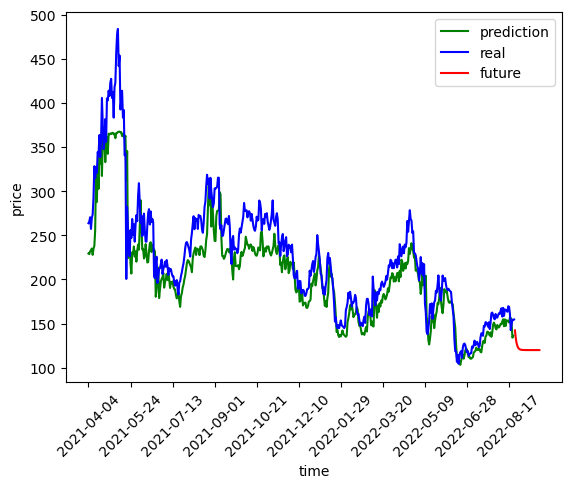

In [158]:
plt.plot(inverse_predictions, color='green', label='prediction')
plt.plot(inverse_test_labels, color='blue', label='real')
plt.plot(inverse_future_preds, color='red', label='future')
plt.xticks(range(0,inverse_test_labels.shape[0],50), test_dates[::50], rotation=45)
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()